For this part of the homework, we will utilize the HAM10000 dataset, which is from the International Skin Imaging Collaboration (ISIC) dataset containing a large collection of skin images used for the classification of skin lesions. Your first task is to review the images in this dataset and compare how the classification in this dataset differs from the other two datasets in this homework. You will then need to modify and run the code to observe how the Convolutional Neural Network (CNN) trained from scratch compares to the fine-tuned VGG16 model for this specific dataset. Additionally, you should compare the performance of the two models between the HAM10000 dataset and the other dataset.

For the coding task, your main objectives are as follows:

+ Modify the data preprocessing functions, dataset class, and data loaders to work with the HAM10000 dataset. Please note that while the wafer dataset is loaded from a pickle file as a pandas dataframe, the HAM10000 dataset consists of images within directories. The directory structure is organized so that the name of the parent directory corresponds to the label of the images. PyTorch provides methods to handle this dataset organization.

+ Modify the custom model and the VGG16 model to work with this  dataset.

# Download Dataset
+ Download dataset from Box
+ (You can download the images to your desktop by using the link https://ucsb.box.com/shared/static/vz9pmd1h7eexf2qxr5odvjy0xew5aqpo.zip)
+ Unzip dataset

In [1]:
!wget -nc -O dataset.zip https://ucsb.box.com/shared/static/vz9pmd1h7eexf2qxr5odvjy0xew5aqpo.zip

--2023-11-18 02:43:38--  https://ucsb.box.com/shared/static/vz9pmd1h7eexf2qxr5odvjy0xew5aqpo.zip
Resolving ucsb.box.com (ucsb.box.com)... 74.112.186.144
Connecting to ucsb.box.com (ucsb.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/vz9pmd1h7eexf2qxr5odvjy0xew5aqpo.zip [following]
--2023-11-18 02:43:38--  https://ucsb.box.com/public/static/vz9pmd1h7eexf2qxr5odvjy0xew5aqpo.zip
Reusing existing connection to ucsb.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ucsb.app.box.com/public/static/vz9pmd1h7eexf2qxr5odvjy0xew5aqpo.zip [following]
--2023-11-18 02:43:38--  https://ucsb.app.box.com/public/static/vz9pmd1h7eexf2qxr5odvjy0xew5aqpo.zip
Resolving ucsb.app.box.com (ucsb.app.box.com)... 74.112.186.144
Connecting to ucsb.app.box.com (ucsb.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcl

In [2]:
!unzip -n dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: datasets/HAM10000/test/not_label/ISIC_0034887.jpg  
  inflating: datasets/HAM10000/test/not_label/ISIC_0034888.jpg  
  inflating: datasets/HAM10000/test/not_label/ISIC_0034889.jpg  
  inflating: datasets/HAM10000/test/not_label/ISIC_0034890.jpg  
  inflating: datasets/HAM10000/test/not_label/ISIC_0034891.jpg  
  inflating: datasets/HAM10000/test/not_label/ISIC_0034895.jpg  
  inflating: datasets/HAM10000/test/not_label/ISIC_0034896.jpg  
  inflating: datasets/HAM10000/test/not_label/ISIC_0034898.jpg  
  inflating: datasets/HAM10000/test/not_label/ISIC_0034899.jpg  
  inflating: datasets/HAM10000/test/not_label/ISIC_0034904.jpg  
  inflating: datasets/HAM10000/test/not_label/ISIC_0034905.jpg  
  inflating: datasets/HAM10000/test/not_label/ISIC_0034906.jpg  
  inflating: datasets/HAM10000/test/not_label/ISIC_0034910.jpg  
  inflating: datasets/HAM10000/test/not_label/ISIC_0034911.jpg  
  inflating: datasets/HAM10000/test/not

# Import libraries

In [3]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.models import vgg16, VGG16_Weights
import numpy as np
import pandas as pd
from typing import Dict, Final, List, Tuple, NamedTuple, Type, Union
from tqdm.auto import tqdm, trange

import cv2

from collections import Counter

import skimage.transform

import matplotlib.pyplot as plt

TODO: Type = NotImplemented

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)


PyTorch Version:  2.1.0+cu118
Torchvision Version:  0.16.0+cu118


# Type Definition
Define some types for clearer labeling of our interfaces.

In [4]:
TODO = NotImplemented  # NOTE: This is a placeholder for code that needs to be written

Loss: Type = float
Accuracy: Type = float


class LossAcc(NamedTuple):
    loss: Loss
    accuracy: Accuracy


class TrainValLossAcc(NamedTuple):
    train: List[List[LossAcc]]
    val: List[LossAcc]


example_result_pair: LossAcc = LossAcc(1.6, 0.7)
print("loss:", example_result_pair.loss)
print("accuracy:", example_result_pair.accuracy)
print(example_result_pair)

loss: 1.6
accuracy: 0.7
LossAcc(loss=1.6, accuracy=0.7)


# Configurations
Some configuration options that are required to make the dataset work with PyTorch.

In [5]:
num_epochs: Final[int] = 20

batch_size: Final[int] = 16

valid_set_size: Final[float] = 0.30

print("Number of epochs: ", num_epochs)
print("Batch size: ", batch_size)


Number of epochs:  20
Batch size:  16


# Loading HAM10000 training data from directory

1. Define Data Transforms:

  + Define data transformations using `transforms.Compose`. This should include
    + Conversion to a tensor. Converts a PIL Image or numpy.ndarray (H x W x C) in the range `[0, 255]` to a torch.FloatTensor of shape (C x H x W) in the range `[0.0, 1.0]`.
    + Resizing to (150, 200). All the images have the same size (450, 600), and we are resizing to (150, 200) to keep the aspect ratio.
    + Optionally, you can include other preprocessing steps.

2. Load the HAM10000 Dataset:

  + Set the path to your HAM10000 `train` dataset directory.
  + Create the dataset using the `datasets.ImageFolder` class. This class automatically assigns labels based on the subdirectory names.

3. Get Class Labels:

  + Obtain the class labels (class names) from the `all_dataset.classes` attribute. This will give you a list of class labels in the order they appear in the dataset.


In [6]:
import torch
from torchvision import transforms, datasets

# Define the data transformations composing of
# - Conversion to a tensor
# - Resize to size (150, 200)
# Compose: https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((150, 200), antialias=True)
])  # CODE HERE

# Set the path to your HAM10000 train dataset directory
data_dir = '/content/datasets/HAM10000/train'  # CODE HERE

# Create a dataset using ImageFolder
# ImageFolder: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
all_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)  # CODE HERE

# get the classes attribute from all_dataset
classes: Final[List[str]] = all_dataset.classes  # CODE HERE

num_classes: Final[int] = len(classes)

PyTorch provides the `torch.utils.data.random_split()` function to split a dataset. This method takes a dataset and a list of lengths/ratios, and returns a list of datasets of the specified lengths/ratios. If lengths are given, the sum of the lengths must equal the length of the original dataset. If ratios are given, the sum of the ratios must equal to 1. In the configuration block above, we have already computed `test_set_sample_count` and `test_set_actual_size` for you, so you can use it to create a train/valid split.

To get a consistent split, you are able to set your own random seed, though the process is more complex than for `scikit-learn`. To do so, add the argument `generator=torch.Generator().manual_seed(9)` to the `random_split()` function call. This split has produced a good class balance in our testing, but you are welcome to experiment with different `valid_set_size` and `manual_seed` values.

In [7]:
# random_split: https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split
total_size = len(all_dataset)
valid_set_size = int(total_size * valid_set_size)
train_set_size = total_size - valid_set_size
generator = torch.Generator().manual_seed(9)
train_dataset, val_dataset = random_split(all_dataset, [train_set_size, valid_set_size], generator=generator)


Once arranged into a `Dataset`, we wrap the `Dataset` in a `Dataloader` object. This object is used to iterate over the dataset in batches, shuffle the dataset, and perform other useful operations, like parallel data loading.

In [8]:
# DataLoader: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

The below visualization of class label balances is provided for your reference. The train/valid split should produce similar class label balances.

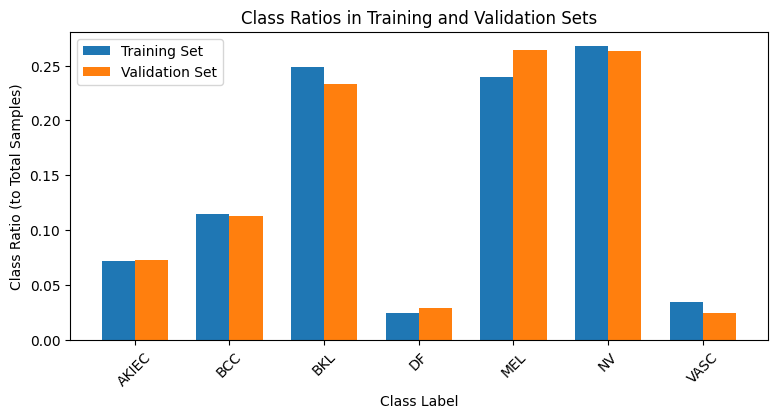

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to plot class label distribution as ratios
def plot_class_distribution_ratios(train_dataset, val_dataset):
    class_counts_train = [0] * len(train_dataset.dataset.classes)
    class_counts_val = [0] * len(val_dataset.dataset.classes)

    for _, label in train_dataset:
        class_counts_train[label] += 1

    for _, label in val_dataset:
        class_counts_val[label] += 1

    # Calculate the total number of samples in the entire dataset
    total_train_samples = sum(class_counts_train)
    total_valid_samples = sum(class_counts_val)

    # Calculate class ratios
    class_ratios_train = [count / total_train_samples for count in class_counts_train]
    class_ratios_val = [count / total_valid_samples for count in class_counts_val]

    class_labels = train_dataset.dataset.classes
    width = 0.35
    x = np.arange(len(class_labels))

    plt.figure(figsize=(9, 4))
    plt.bar(x - width/2, class_ratios_train, width, label='Training Set')
    plt.bar(x + width/2, class_ratios_val, width, label='Validation Set')
    plt.xlabel('Class Label')
    plt.ylabel('Class Ratio (to Total Samples)')
    plt.title('Class Ratios in Training and Validation Sets')
    plt.xticks(x, class_labels, rotation=45)
    plt.legend()
    plt.show()

# Plot class ratios for training and validation sets
plot_class_distribution_ratios(train_dataset, val_dataset)

# Custom Neural Network Model

Now we'll define a new network. We'll use this network to train on the HAM10000 dataset. We'll use the `torch.nn` module to define the network. This module provides a number of useful building blocks for neural networks, including linear layers, convolution layers, dropout layers, maxpooling layers, activation functions, flatten function, and loss functions.

If this is your absolute first interaction with PyTorch, you may find [this basic tutorial link](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html) and [this CNN tutorial link](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network) to be of use.

In [13]:
import torch.nn as nn

class HAM10000Network(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(HAM10000Network, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 9 * 12, 128)  # Adjust the input size based on your needs
        self.fc2 = nn.Linear(128, 7)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.dropout(x)  # Apply dropout after the first convolutional layer
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.dropout(x)  # Apply dropout after the second convolutional layer
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.dropout(x)  # Apply dropout after the third convolutional layer
        x = self.pool(nn.functional.relu(self.conv4(x)))
        x = self.dropout(x)  # Apply dropout after the fourth convolutional layer
        x = x.view(x.size(0), -1)  # Adjust the input size based on your needs
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the first fully connected layer
        x = self.fc2(x)
        return x

# Create an instance of the HAM10000Network model with dropout
dropout_prob = 0.2  # You can adjust the dropout probability as needed
model = HAM10000Network(dropout_prob)


# Validate Function

We will define the `validate` function that evaluates the performance of the model after every training epoch. This function simply puts the network into `eval` mode, then iterates over the validation dataset and computes the accuracy and loss of the network.

Accuracy computations you can perform in similar manner as you have in the past assignments. For loss computations, we will use the `torch.nn.functional.cross_entropy` function, which assumes the network outputs class logits, and computes the cross entropy loss between the logits and the ground truth labels.

Some components of models behave differently whether they're under training or validation. For example, dropout layers will randomly drop out nodes during training, but will not do so during validation. To handle this, PyTorch provides the `.train()` method to set the model into training mode and the `.eval()` method to set the model into validation mode. We will use this to set the model into validation mode before computing the accuracy and loss.

Running data through a model is as simple as treating the model as a function! That is, `model(data)` will run the data through the model and return the output. We can then use this output to compute the accuracy and loss.

The result of `torch.tensor` computations is always more `torch.tensor`s, so use the `.item()` method to get the actual value of the loss and/or accuracy when you are ready to store it.

To leverage a GPU for speeding up the computation, you should move the model, data, and labels to the GPU when a GPU is available.

In [14]:
def validate(model: nn.Module, val_data: DataLoader) -> LossAcc:
    """
    Returns the loss and accuracy of the model on the validation data.
    """
    # Check for GPU availability and set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move the model to the specified device
    model.to(device)

    # Set model to evaluation mode
    model.eval()

    # Initialize variables for tracking loss and accuracy
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    # No gradient computation block
    with torch.no_grad():
        # Iterate through validation data
        for data, labels in val_data:
            # Move data and labels to the device
            data, labels = data.to(device), labels.to(device)

            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(data)

            # Calculate batch loss
            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.item()

            # Convert output probabilities to predicted class (get the index of the max probability)
            _, preds = torch.max(outputs, 1)

            # Count correct predictions
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate average loss and accuracy over all validation data
    average_loss = total_loss / len(val_data)
    accuracy = total_correct / total_samples

    return LossAcc(loss=average_loss, accuracy=accuracy)

# Training Functions
Now, to train a model, we have to write training functions. To ease understanding, we've broken the writing of a "training loop" into three functions: `train_batch` to handle a single batch, `train_epoch` to handle a single epoch, and `train_loop` to handle training as many steps as you would like.

Remember, we're still using `nn.functional.cross_entropy` to compute the loss. Don't forget to set the model to `.train()` mode before training!

After setting the model to training, we need to zero out the gradients from the previous step. This is because PyTorch accumulates gradients from each step, and we don't want to accumulate multiple steps of gradients after we've already used their gradients to update the model. We can zero out the gradients by calling the `.zero_grad()` method on the optimizer. Once we've computed the loss, we can call the `.backward()` method on the loss to compute the gradients. Finally, we can call the `.step()` method on the optimizer to update the model weights.

To leverage a GPU for speeding up the computation, you should move the model, data, and labels to the GPU when a GPU is available.

In [15]:
import torch.nn.functional as F
def train_batch(model: nn.Module, optimizer: optim.Optimizer, inputs: torch.Tensor, labels: torch.Tensor) -> LossAcc:
    """
    Trains the model on a single batch of data.
    Returns the loss and accuracy of the model on the batch.
    """
    # Set model to training mode
    model.train()

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass: compute predicted outputs by passing inputs to the model
    outputs = model(inputs)

    # Calculate the loss
    loss = F.cross_entropy(outputs, labels)

    # Backpropagate: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Perform a single optimization step (parameter update)
    optimizer.step()

    with torch.no_grad():
        # Calculate the accuracy
        _, preds = torch.max(outputs, 1)
        accuracy = torch.sum(preds == labels).item() / labels.size(0)

    # Return the loss and accuracy
    return LossAcc(loss.item(), accuracy)

def train_epoch(model: nn.Module, optimizer: optim.Optimizer, train_data: DataLoader) -> List[LossAcc]:
    """
    Trains the model on a single epoch of data.
    Returns a list of the loss and accuracy of the model on each batch.
    """
    # Check for GPU availability and set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move the model to the GPU
    model.to(device)

    batch_loss_accs = []

    # Iterate through training data
    for inputs, labels in train_data:
        inputs, labels = inputs.to(device), labels.to(device)

        loss_acc = train_batch(model, optimizer, inputs, labels)
        batch_loss_accs.append(loss_acc)

    return batch_loss_accs


def train_loop(model: nn.Module, optimizer: optim.Optimizer, train_data: DataLoader, val_data: DataLoader, num_epochs: int = 10) -> TrainValLossAcc:
    """
    Trains the model for a number of epochs and evaluates it on the validation set.
    """
    train_loss_accs = []
    val_loss_accs = []

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in tqdm(range(num_epochs), desc='Training progress...'):
        # Train the model for one epoch
        train_epoch_loss_acc = train_epoch(model, optimizer, train_data)
        train_loss_accs.append(train_epoch_loss_acc)

        # Validate the model
        val_loss_acc = validate(model, val_data)

        # Store validation results
        val_loss_accs.append(val_loss_acc)

        # Check for best model
        if val_loss_acc.loss < best_val_loss:
            best_val_loss = val_loss_acc.loss
            best_model_state = model.state_dict()

    # Load the best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    return TrainValLossAcc(train_loss_accs, val_loss_accs)

# Train Custom Neural Network
Finally, we can train your neural network! We'll use basic Stochastic Gradient Descent (SGD) as the optimization routine to train the network. We'll use a learning rate of 0.1, and train for 20 epochs. Feel free to change the optimizer and training epochs.

In [16]:
# Create optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Train the model
history: TrainValLossAcc = train_loop(model, optimizer, train_dataloader, val_dataloader, num_epochs)  # CODE HERE

Training progress...:   0%|          | 0/20 [00:00<?, ?it/s]

We provide this visualization code, to give you a picture of what your model learned while it was training.

In [17]:
training_history = pd.DataFrame.from_records(
    [loss for batch_losses in history.train for loss in batch_losses],
    columns=LossAcc._fields,
)
training_history["epoch"] = training_history.index / len(train_dataloader)
validation_history = pd.DataFrame.from_records(history.val, columns=LossAcc._fields)
validation_history["epoch"] = validation_history.index + 1


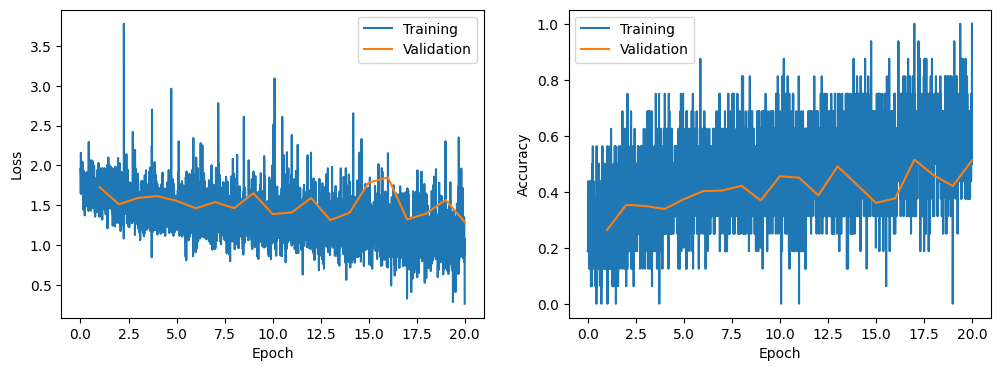

In [18]:

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(training_history["epoch"], training_history["loss"], label="Training")
ax[0].plot(validation_history["epoch"], validation_history["loss"], label="Validation")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[1].plot(training_history["epoch"], training_history["accuracy"], label="Training")
ax[1].plot(
    validation_history["epoch"], validation_history["accuracy"], label="Validation"
)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.show()

In [19]:
# Get the validation accuracy of the best model
# Get the accuracy corresponding to the lowest loss
lowest_loss = validation_history['loss'].min()
best_accuracy = validation_history.loc[validation_history['loss'] == lowest_loss, 'accuracy'].item()
print(f'Best validation accuracy during training: {best_accuracy}')

Best validation accuracy during training: 0.5121951219512195


# Test Data Prediction: Custom Neural Network Model
Make Predictions for the Test Data. This function is already defined for you, you just need to call it and pass in the required parameters.

In [20]:
def generate_test_predictions(model, data_transforms, test_data_dir, output_csv_path, classes):
    # Create a DataLoader for the test dataset
    test_dataset = datasets.ImageFolder(test_data_dir, transform=data_transforms)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Load the pre-trained model
    model.eval()

    # Initialize lists to store filenames and predicted class labels
    filenames = []
    predicted_labels = []

    # Iterate through the test dataset and make predictions
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Convert integer labels to class names
            predicted_class_names = [classes[p] for p in predicted]

            # predicted class labels
            predicted_labels.extend(predicted_class_names)


    # Get the basenames of the files
    basenames = [os.path.basename(filename) for filename, _ in test_dataset.imgs]

    # Create a DataFrame to store basenames and predicted labels
    data = {'Basename': basenames, 'Predictions': predicted_labels}
    df = pd.DataFrame(data)

    # Sort the DataFrame by Basename
    df.sort_values(by='Basename', inplace=True)

    # drop the Basename column
    df.drop(columns=['Basename'], inplace=True)

    # Save the sorted predictions to a CSV file
    df.to_csv(output_csv_path, index=False)
    print(f'Predictions saved to {output_csv_path}')

In [21]:
# Generate test predictions and output the predictions to CSV named 'ham10000_custom_nn_prediction.csv'
generate_test_predictions(
    model = model , # CODE HERE
    data_transforms = data_transforms , # CODE HERE
    test_data_dir = '/content/datasets/HAM10000/test' , # CODE HERE
    output_csv_path = 'ham10000_custom_nn_prediction.csv' , # CODE HERE
    classes = classes , # CODE HERE
)

Predictions saved to ham10000_custom_nn_prediction.csv


# Fine-Tune VGG16

Now, we will be fine-tuning a VGG16 model to perform the same HAM10000 classification task and compare the performance against the custom model which is trained from scratch.

# Loading HAM10000 training data from directory (VGG16)

1. Define Data Transforms:

  + Define data transformations using `transforms.Compose`. This should include
    + Padding to make the image a square.
    + Conversion to a tensor. Converts a PIL Image or numpy.ndarray (H x W x C) in the range `[0, 255]` to a torch.FloatTensor of shape (C x H x W) in the range `[0.0, 1.0]`.
    + Resizing to (224, 224).
    + Normalization using the mean and standard deviation values `[0.485, 0.456, 0.406]` and `[0.229, 0.224, 0.225]`. These values are used for the pre-train ImageNet Dataset to set the values to be in the range `[-1, 1]`.
    + Optionally, you can include other preprocessing steps.
  + Padding is added to maintain the aspect ratio when resizing to (224, 224). The resizing to (224, 224) and normalization are performed to ensure that the images match the input shape of VGG16 in the later parts.

2. Load the HAM10000 Dataset:

  + Set the path to your HAM10000 `train` dataset directory.
  + Create the dataset using the `datasets.ImageFolder` class. This class automatically assigns labels based on the subdirectory names.

3. Get Class Labels:

  + Obtain the class labels (class names) from the `all_dataset.classes` attribute. This will give you a list of class labels in the order they appear in the dataset.

In [ ]:
from PIL import Image

# Define a custom data transform to pad the image to be square
class SquarePad(object):
    def __init__(self, fill_color=(0, 0, 0)):
        self.fill_color = fill_color

    def __call__(self, img):
        width, height = img.size

        # Calculate the size of the square canvas
        size = max(width, height)

        # Create a new blank image with the square size
        new_img = Image.new('RGB', (size, size), self.fill_color)

        # Paste the original image onto the center of the square canvas
        new_img.paste(img, ((size - width) // 2, (size - height) // 2))

        return new_img

In [ ]:
import torch
from torchvision import transforms, datasets

# Define the data transformations composing of
# - Padding to make the image a square
# - Conversion to a tensor
# - Resize to size (224, 224)
# - Normalization using the mean and standard deviation values
#  `[0.485, 0.456, 0.406]` and `[0.229, 0.224, 0.225]`
# Compose: https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html
data_transforms = transforms.Compose([
    SquarePad(),
    transforms.ToTensor(),
    transforms.Resize((224, 224),antialias=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])  # CODE HERE

# Create a dataset using ImageFolder
# ImageFolder: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
all_dataset = datasets.ImageFolder(root='/content/datasets/HAM10000/train', transform=data_transforms) # CODE HERE

Split Dataset into training and validation

In [ ]:
# random_split: https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split
total_size = len(all_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
train_dataset, val_dataset =  random_split(all_dataset, [train_size, val_size]) # CODE HERE

Once arranged into a `Dataset`, we wrap the `Dataset` in a `Dataloader` object.

In [ ]:
# DataLoader: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)  # CODE HERE
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2) # CODE HERE

# Overview of Fine-Tuning VGG16

VGG16 is a popular deep convolutional neural network architecture used for various computer vision tasks. It consists of two main components: the "features" part and the "classifier" part. Fine-tuning VGG16 involves adjusting these components to adapt the pre-trained model to a new task.

Components of VGG16
1. Features Layers:
The "features" part of VGG16 comprises a stack of convolutional and max-pooling layers. These layers serve as feature extractors and are responsible for capturing hierarchical features from the input image.
These layers are typically frozen during fine-tuning when using transfer learning. Freezing means that the weights of these layers are not updated during training to preserve the pre-trained knowledge.
2. Classifier Layers:
The "classifier" part of VGG16 consists of fully connected layers (also known as dense layers). These layers are responsible for making predictions based on the extracted features.
During fine-tuning, the classifier layers are often replaced by a new set of fully connected layers to adapt the model to the specific task.
---

Load the Pre-Trained VGG16 Model:

Begin by loading the pre-trained VGG16 model with weights 'IMAGENET1K_V1', which includes both the features and classifier components. You can do this using PyTorch's torchvision.models.

In [ ]:
import torchvision.models as models

# load VGG16 models with weights 'IMAGENET1K_V1'
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)# CODE HERE

Freeze the Features Layers:

Disable gradient updates to prevent them from changing during training. This step ensures that the model retains its ability to extract relevant features from the data.

In [ ]:
# Get the features part of the model
features =  model.features  # CODE HERE

# Freeze the feature layers
# CODE HERE
for param in features.parameters():
    param.requires_grad = False

Define and Replace the Classifier:


+ Replace only the last layer to have 7 output units for the HAM10000 dataset. Note: Last classifier layer has 4096 input units.
+ Set the last layer to require gradients for fine-tuning.

In [ ]:
# Modify the last layer to have 7 output units for the HAM10000 dataset
# CODE HERE
classifier = model.classifier
classifier[6] = nn.Linear(4096, 7)
# Set the last layer to require gradients for fine-tuning
# CODE HERE
for param in classifier[6].parameters():
    param.requires_grad = True

model.classifier = classifier


# Fine-Tune VGG16 Model

In [ ]:
# Create optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
history: TrainValLossAcc = train_loop(model, optimizer, train_dataloader, val_dataloader, num_epochs)  # CODE HERE

Training progress...:   0%|          | 0/20 [00:00<?, ?it/s]

We provide this visualization code, to give you a picture of what your model learned while it was training.

In [ ]:
training_history = pd.DataFrame.from_records(
    [loss for batch_losses in history.train for loss in batch_losses],
    columns=LossAcc._fields,
)
training_history["epoch"] = training_history.index / len(train_dataloader)
validation_history = pd.DataFrame.from_records(history.val, columns=LossAcc._fields)
validation_history["epoch"] = validation_history.index + 1


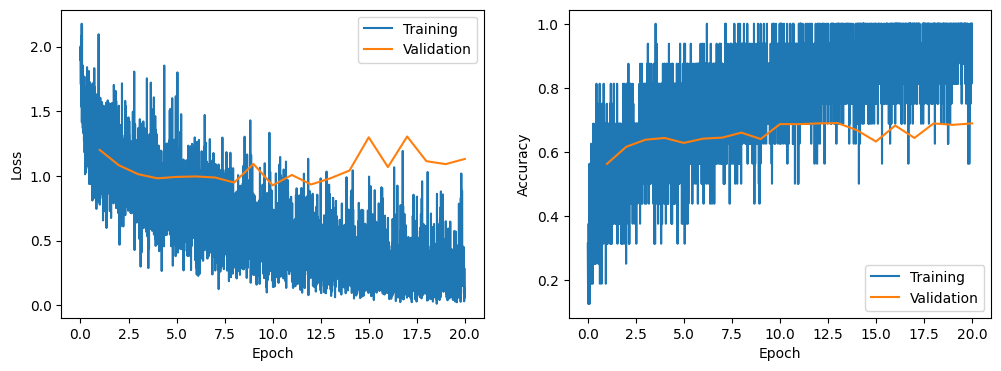

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(training_history["epoch"], training_history["loss"], label="Training")
ax[0].plot(validation_history["epoch"], validation_history["loss"], label="Validation")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[1].plot(training_history["epoch"], training_history["accuracy"], label="Training")
ax[1].plot(
    validation_history["epoch"], validation_history["accuracy"], label="Validation"
)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.show()

In [ ]:
# Get the validation accuracy of the best model
# Get the accuracy corresponding to the lowest loss
lowest_loss = validation_history['loss'].min()
best_accuracy = validation_history.loc[validation_history['loss'] == lowest_loss, 'accuracy'].item()
print(f'Best validation accuracy during training: {best_accuracy}')

Best validation accuracy during training: 0.6862527716186253


# Test Data Prediction: VGG16


In [ ]:
# Generate test predictions and output the predictions to CSV named 'ham10000_vgg16_nn_prediction.csv'
generate_test_predictions(
    model = model , # CODE HERE
    data_transforms = data_transforms , # CODE HERE
    test_data_dir = '/content/datasets/HAM10000/test' , # CODE HERE
    output_csv_path = 'ham10000_vgg16_nn_prediction.csv' , # CODE HERE
    classes = classes , # CODE HERE
)

Predictions saved to ham10000_vgg16_nn_prediction.csv
